In [1]:
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import io, restoration, img_as_float

In [11]:
import numpy as np
import scipy.ndimage

def estimate_gradients(image):
    """Estimate gradients using Sobel filters."""
    gx = scipy.ndimage.convolve(image, np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]), mode='nearest')
    gy = scipy.ndimage.convolve(image, np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]), mode='nearest')
    return gx, gy

def estimate_ci_matrix(gradients):
    """Estimate Ci matrix based on gradients."""
    gx, gy = gradients
    return np.diag(gx**2 + gy**2)

def lark_kernel(xi, xj, ci):
    """LARK kernel function."""
    return np.exp(-(xi - xj)**2 * ci)

def lark_filter(image, patch_size, sigma):
    """LARK filtering."""
    height, width = image.shape
    output_image = np.zeros_like(image)

    for i in range(patch_size, height - patch_size):
        for j in range(patch_size, width - patch_size):
            patch = image[i - patch_size:i + patch_size + 1, j - patch_size:j + patch_size + 1]
            gradients = estimate_gradients(patch)
            ci_matrix = estimate_ci_matrix(gradients)

            weights = np.zeros_like(patch)
            for m in range(patch_size):
                for n in range(patch_size):
                    xi = patch[m, n]
                    for k in range(patch_size):
                        for l in range(patch_size):
                            xj = patch[k, l]
                            weights[m, n] += lark_kernel(xi, xj, ci_matrix[m, n])

            weights /= np.sum(weights)
            output_image[i, j] = np.sum(weights * patch)

    return output_image

# Example usage
image = np.zeros((10,10))
image[5:,5] = 1
filtered_image = lark_filter(image, patch_size=5, sigma=1)

In [9]:
filtered_image

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [5]:
def patch_similarity(patch1, patch2, h):
    """Calculates similarity between two patches."""
    diff = patch1 - patch2
    return np.exp(-np.sum(diff ** 2) / (h ** 2))

def non_local_means(image, patch_size=5, search_window=7, h=10):
    """Applies Non-Local Means denoising algorithm on an image."""
    filtered_image = np.zeros_like(image)
    half_patch = patch_size // 2
    half_window = search_window // 2
    
    # Padding to handle edge cases
    padded_image = np.pad(image, ((half_window, half_window), (half_window, half_window)), mode='reflect')

    # Iterate over each pixel in the image
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            reference_patch = padded_image[i+half_window-half_patch:i+half_window+half_patch+1,
                                           j+half_window-half_patch:j+half_window+half_patch+1]
            
            # Ensure valid patch size
            if reference_patch.shape != (patch_size, patch_size):
                continue

            weighted_sum = 0
            normalization = 0

            # Search for similar patches in the search window
            for k in range(-half_window, half_window + 1):
                for l in range(-half_window, half_window + 1):
                    current_patch = padded_image[i+k+half_window-half_patch:i+k+half_window+half_patch+1,
                                                 j+l+half_window-half_patch:j+l+half_window+half_patch+1]
                    
                    # Skip invalid patches that are out of bounds
                    if current_patch.shape != (patch_size, patch_size):
                        continue
                    
                    weight = patch_similarity(reference_patch, current_patch, h)
                    weighted_sum += weight * padded_image[i+k+half_window, j+l+half_window]
                    normalization += weight
            
            # Update the pixel value after normalization
            filtered_image[i, j] = weighted_sum / normalization if normalization > 0 else padded_image[i+half_window, j+half_window]

    return filtered_image

In [6]:
def compute_structure_tensor(patch):
    grad_x = np.gradient(patch, axis=1)
    grad_y = np.gradient(patch, axis=0)
    
    Ixx = grad_x ** 2
    Iyy = grad_y ** 2
    Ixy = grad_x * grad_y
    
    structure_tensor = np.array([[np.sum(Ixx), np.sum(Ixy)], 
                                 [np.sum(Ixy), np.sum(Iyy)]])
    return structure_tensor

def lark_filter(image, patch_size=3, h=1):
    filtered_image = np.zeros_like(image)
    half_patch = patch_size // 2
    
    padded_image = np.pad(image, ((half_patch, half_patch), (half_patch, half_patch)), mode='reflect')
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            patch = padded_image[i:i+patch_size, j:j+patch_size]
            center_pixel = padded_image[i+half_patch, j+half_patch]
            
            # Compute structure tensor
            C = compute_structure_tensor(patch)
            
            # Locally adaptive kernel using the structure tensor
            distances = np.arange(-half_patch, half_patch + 1)
            x, y = np.meshgrid(distances, distances)
            positions = np.stack([x, y], axis=-1)
            
            weights = np.exp(-0.5 * np.sum(positions @ np.linalg.inv(C) * positions, axis=-1))
            
            filtered_pixel = np.sum(weights * patch) / np.sum(weights)
            filtered_image[i, j] = filtered_pixel
    
    return filtered_image


# Import and Add noise to image

In [7]:
# Function to load and normalize an image
def load_and_normalize_image(image_path):
    # Load the image and convert to grayscale
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image_array = np.asarray(image, dtype=np.float32)
    
    # Normalize the image to the range [0, 1]
    normalized_image = image_array / 255.0
    return normalized_image

def load_image(image_path):
    # Load the image and convert to grayscale
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image_array = np.asarray(image, dtype=np.float32)
    
    # Normalize the image to the range [0, 1]
    normalized_image = image_array 
    return normalized_image

# Function to add salt-and-pepper noise to an image
def add_salt_and_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    noisy_image = np.copy(image)
    num_salt = np.ceil(salt_prob * image.size)
    num_pepper = np.ceil(pepper_prob * image.size)

    # Add salt (white pixels)
    salt_coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy_image[salt_coords[0], salt_coords[1]] = 1

    # Add pepper (black pixels)
    pepper_coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0
    
    return noisy_image

def add_gaussian_noise(image, mean=0, sigma=25):
    # Generate Gaussian noise
    gaussian_noise = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
    
    # Add the noise to the image and clip the values to [0, 255]
    noisy_image =image+gaussian_noise
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image


# Function to calculate MSE (Mean Squared Error)
def calculate_mse(original, noisy):
    mse = np.mean((original - noisy) ** 2)
    return mse

# Function to calculate PSNR (Peak Signal-to-Noise Ratio)
def calculate_psnr(original, noisy):
    mse = calculate_mse(original, noisy)
    if mse == 0:
        return float('inf')  # Return infinity if images are identical
    max_pixel = 1.0  # Assuming the images are normalized to range [0, 1]
    psnr = 10 * np.log10(max_pixel**2 / mse)
    return psnr

# Function to plot original and noisy images side by side and display PSNR
def plot_images(original, noisy):
    psnr_value = calculate_psnr(original, noisy)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Original image
    ax[0].imshow(original, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Noisy image with PSNR
    ax[1].imshow(noisy, cmap='gray')
    ax[1].set_title(f'Noisy Image (PSNR: {psnr_value:.2f} dB)')
    ax[1].axis('off')

    plt.show()


In [8]:
def normalize_to_01(array):
    """
    Normalize a 2D NumPy array to the range [0, 1].

    Parameters:
    - array: Input 2D NumPy array.

    Returns:
    - normalized_array: Normalized 2D NumPy array.
    """
    min_val = np.min(array)
    max_val = np.max(array)

    # Perform min-max normalization
    normalized_array = (array - min_val) / (max_val - min_val)
    return normalized_array

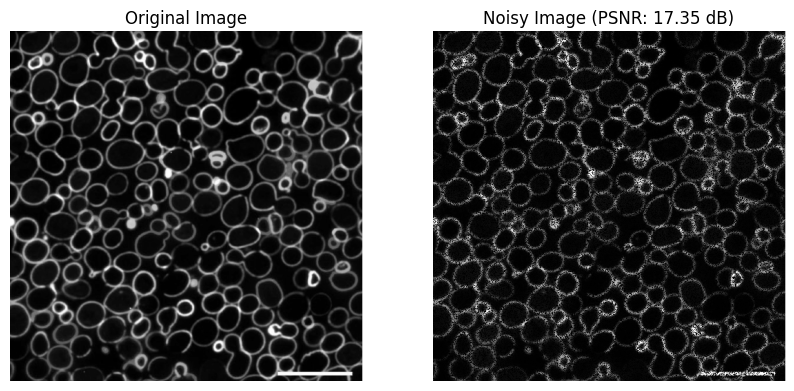

In [13]:
image_path = '/home/arman/Documents/arman/Uni/Master/Semester 3/Computational Machine Vison/Dataset/train/339_img.png' 
image = load_image(image_path)

noisy_image = add_salt_and_pepper_noise(image, salt_prob=0.2, pepper_prob=0.2)
# noisy_image = add_gaussian_noise(image, mean=0, sigma=0.4)
image = normalize_to_01(image)
noisy_image = normalize_to_01(noisy_image)
# Plot the images
plot_images(image, noisy_image)


In [101]:
image

array([[0.00666667, 0.00666667, 0.00666667, ..., 0.06666667, 0.06      ,
        0.99333334],
       [0.00666667, 0.00666667, 0.00666667, ..., 0.1       , 0.06      ,
        0.99333334],
       [0.00666667, 0.00666667, 0.00666667, ..., 0.12      , 0.08      ,
        0.99333334],
       ...,
       [0.21333334, 0.11333334, 0.07333333, ..., 0.02      , 0.00666667,
        0.99333334],
       [0.16      , 0.07333333, 0.05333333, ..., 0.02      , 0.00666667,
        0.99333334],
       [0.11333334, 0.04      , 0.03333334, ..., 0.01333333, 0.00666667,
        0.99333334]], dtype=float32)

# Bilateral

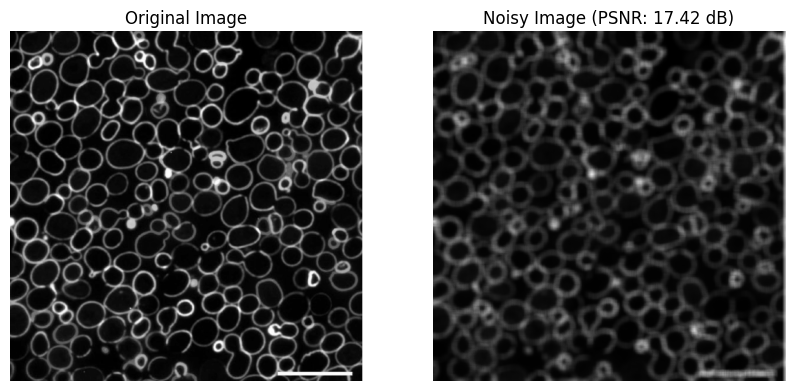

In [14]:
denoised_image = bilateral_filter(noisy_image, d=9, sigma_color=75, sigma_space=75)
plot_images(image, denoised_image)

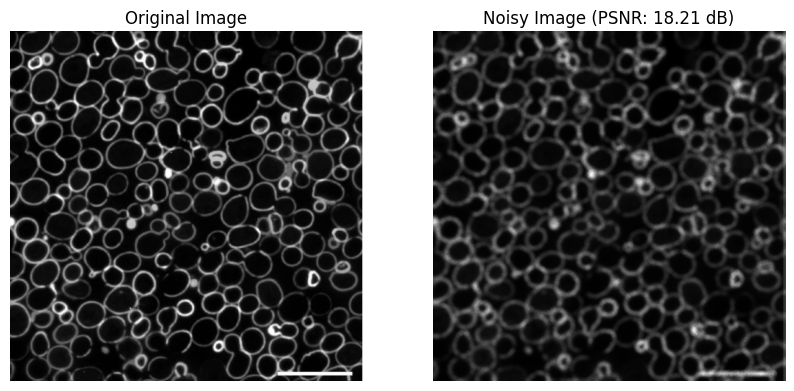

In [15]:
# Apply bilateral filter
denoised_image = cv.bilateralFilter(noisy_image, d=9, sigmaColor=75, sigmaSpace=75)
plot_images(image, denoised_image)

# Non local means

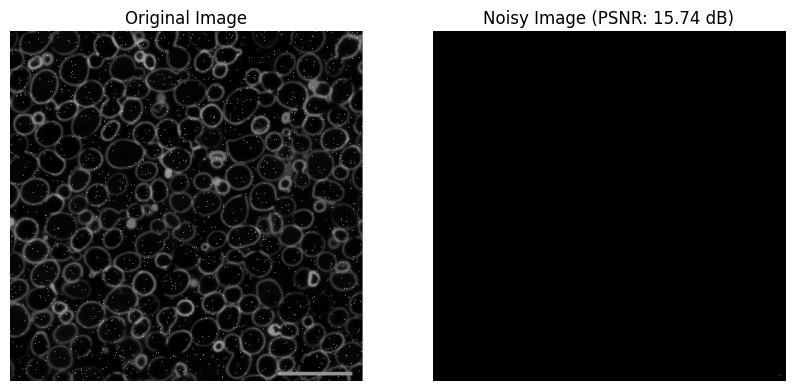

In [107]:
# Example usage
denoised_image = non_local_means(noisy_image, patch_size=20, search_window=3, h=0.5)
plot_images(noisy_image, denoised_image)

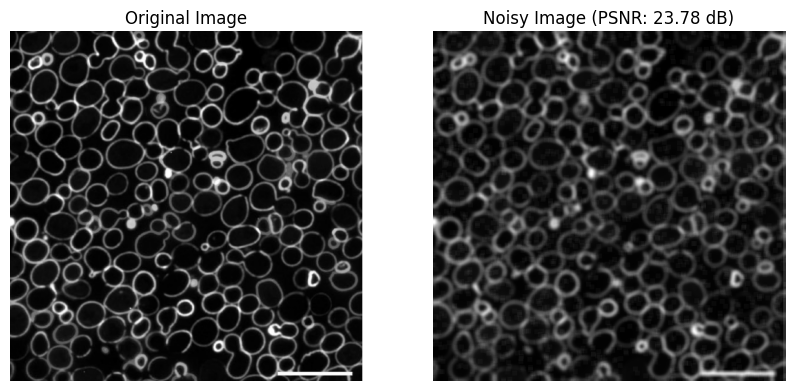

In [108]:
# Load and normalize an image
image = img_as_float(io.imread(image_path, as_gray=True))
noisy_image = add_salt_and_pepper_noise(image=image)
# Apply Non-Local Means denoising
denoised_image = restoration.denoise_nl_means(noisy_image, patch_size=20, patch_distance=3, h=0.5)
plot_images(image, denoised_image)

# Anisotropic Diffusion

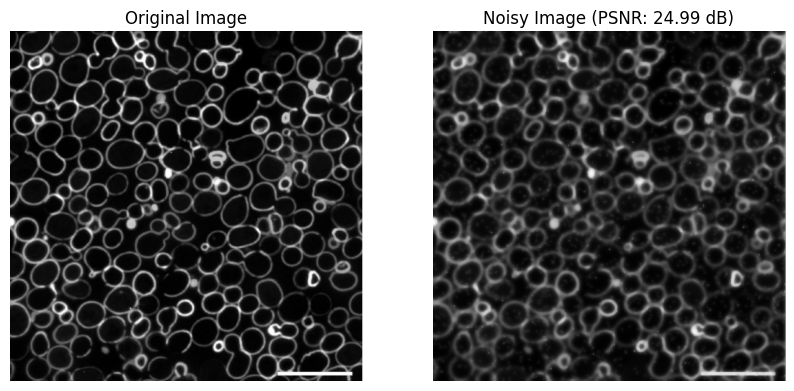

In [113]:
# Apply anisotropic diffusion (also known as Perona-Malik filter)
denoised_image = restoration.denoise_tv_chambolle(noisy_image, weight=0.3)
plot_images(image, denoised_image)

# Medien Filter

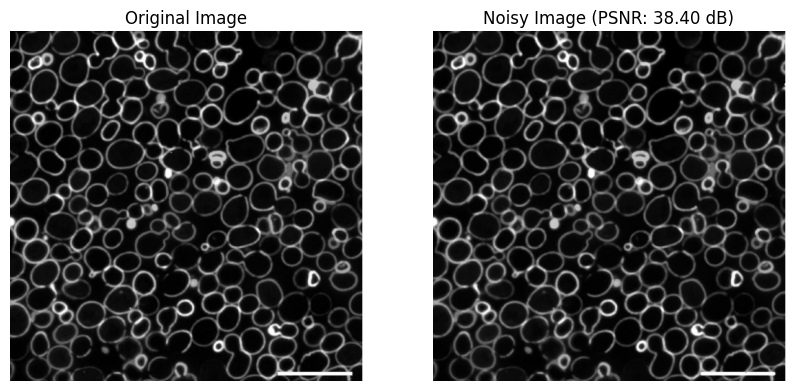

In [52]:
from skimage import filters

# Apply Median filtering
denoised_image = filters.median(noisy_image)

plot_images(image, denoised_image)


# BM3D

In [7]:
from scipy.fftpack import dct, idct
from skimage.util import view_as_windows

def block_matching(img, block_size=8, search_area=15):
    """Find similar patches in the image."""
    padded_img = np.pad(img, search_area, mode='symmetric')
    h, w = img.shape
    blocks = []
    indices = []
    
    for i in range(h):
        for j in range(w):
            # Extract the patch
            patch = padded_img[i:i + block_size, j:j + block_size]
            # Define the search region
            search_region = padded_img[i:i + block_size + 2 * search_area, j:j + block_size + 2 * search_area]
            # Find similar patches
            for si in range(-search_area, search_area + 1):
                for sj in range(-search_area, search_area + 1):
                    if si == 0 and sj == 0:
                        continue
                    neighbor_patch = search_region[si + search_area:si + search_area + block_size,
                                                    sj + search_area:sj + search_area + block_size]
                    # Store the blocks and their positions
                    blocks.append(patch.flatten())
                    indices.append((i, j))
    return np.array(blocks), indices

def collaborative_filtering(blocks, sigma):
    """Apply collaborative filtering using Wiener filter."""
    # DCT transform
    transformed_blocks = dct(blocks, axis=1, norm='ortho')
    # Estimate noise
    noise_variance = sigma**2
    # Apply Wiener filter
    filtered_blocks = np.zeros_like(transformed_blocks)
    
    for i in range(transformed_blocks.shape[0]):
        block = transformed_blocks[i]
        snr = np.mean(block**2) / noise_variance
        filtered_block = (snr / (snr + 1)) * block
        filtered_blocks[i] = filtered_block
    
    # Inverse DCT transform
    return idct(filtered_blocks, axis=1, norm='ortho')

def aggregate_patches(filtered_blocks, indices, block_size):
    """Aggregate denoised patches back into the image."""
    output_img = np.zeros((filtered_blocks.shape[0]//(block_size**2), block_size))
    count_map = np.zeros_like(output_img)

    for i, (x, y) in enumerate(indices):
        output_img[x:x + block_size, y:y + block_size] += filtered_blocks[i].reshape((block_size, block_size))
        count_map[x:x + block_size, y:y + block_size] += 1

    return output_img / count_map

def bm3d_denoise(img, sigma):
    """Full BM3D denoising process."""
    blocks, indices = block_matching(img)
    filtered_blocks = collaborative_filtering(blocks, sigma)
    denoised_img = aggregate_patches(filtered_blocks, indices, block_size=8)
    return denoised_img


In [8]:
img = cv.imread(image_path, cv.IMREAD_GRAYSCALE) / 255.0
sigma = 0.1  # Noise standard deviation
noisy_image = add_salt_and_pepper_noise(img)
# denoised_img = bm3d_denoise(noisy_image, sigma)
# plot_images(img, denoised_image)

# Locally Adaptive Regression Kernels (LARK)

In [ ]:
denoised_disctionary = denoiser.denoise_with_dictionary_learning(patch_size=8, n_components=250, alpha=1)
# Plot the images
helper_func.plot_images(original=image, noisy=noisy_image, denoised_image=denoised_disctionary, method_name=method_name, noise_type=noise_type)

In [ ]:
from PIL import Image
import numpy as np


def anisotropic_diffusion(image, num_iterations=10, k=5, delta_t=1):
    """
    Performs anisotropic diffusion denoising on an image.

    Args:
        image: The input image as a NumPy array.
        num_iterations: Number of iterations for the diffusion process (default: 10).
        k: Constant controlling the sensitivity to gradients (default: 5).
        delta_t: Time step for the diffusion process (default: 1).

    Returns:
        The denoised image as a NumPy array.
    """

    # Pad the image with a single pixel reflection at the borders
    padded_image = np.pad(image, pad_width=1, mode='reflect')

    # Calculate image dimensions after padding
    image_height, image_width = image.shape

    for _ in range(num_iterations):
        # Calculate gradients within the valid image region (avoid padded pixels)
        dx = padded_image[1:image_height + 1, 1:image_width + 1] - padded_image[1:image_height + 1, :image_width]
        dy = padded_image[1:image_height + 1, 1:image_width + 1] - padded_image[:image_height, 1:image_width + 1]

        # Calculate absolute gradients and diffusion coefficients
        abs_dx = np.abs(dx)
        abs_dy = np.abs(dy)
        c_x = np.exp(-(abs_dx / k) ** 2)
        c_y = np.exp(-(abs_dy / k) ** 2)

        # Update image within the valid region
        image[1:, :-1] += delta_t * (c_x[:-1, :] * dx[:-1, :] + c_y[:-1, :] * (padded_image[2:image_height + 2, 1:image_width + 1] - padded_image[1:image_height + 1, 1:image_width + 1]))
        image[:-1, 1:] += delta_t * (c_x[:, :-1] * (padded_image[1:image_height + 1, 2:image_width + 2] - padded_image[1:image_height + 1, 1:image_width + 1]) + c_y[:, :-1] * dy[:, :-1])
        return np.clip(image, 0, 1)


# Apply anisotropic diffusion
denoised_image = anisotropic_diffusion(image)

# Save the denoised image using PIL
denoised_image_pil = Image.fromarray(denoised_image)
denoised_image_pil.save('denoised_image.jpg')